# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21
import torch

from fastai.distributed import *
from fastai.text.models.transformer import *

import numpy as np

from fastai_data import *
from lmnp_transformer import *
from encode_data import *

In [3]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [4]:
bs=16
bptt=256

In [5]:
transpose_tfm = partial(rand_transpose, enc_offset=ENC_OFFSET, rand_range=(0,12))

In [6]:
path = Path('data/midi/v9/midi_encode/np/shortdur/')
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/hook', train_tfms=[transpose_tfm])

In [7]:
VOCAB_SZ = create_vocab_sizes(path/'tmp/all')
N_COMPS = len(VOCAB_SZ)
N_EMBS = 128
EMB_IDXS = range(N_COMPS)
EMB_DIM = [N_EMBS]*len(EMB_IDXS)
EMB_MAP = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
EMB_MAP

[(0, 130, 128), (1, 132, 128)]

In [8]:
idx2embidx = { i:EMB_MAP[i] for i in range(N_COMPS) }
total_embs = sum([v[-1] for k,v in idx2embidx.items()])

In [9]:
config = tfmerXL_lm_config
config['emb_map'] = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
config['idx_map'] = idx2embidx
config['loss_weights'] = [1,1] # note,duration
config['pad_idx'] = PADDING_IDX+ENC_OFFSET
config['bos_idx'] = VALTBOS+ENC_OFFSET
config['mask_type'] = MaskType.RandomWindow
config['act'] = Activation.ReLU

config['d_model'] = total_embs
config['mem_len'] = 512

config['resid_p'] = 0.1
config['attn_p'] = 0.1 # attention dropout
config['ff_p'] = 0.1
config['embed_p'] = 0.1 # embedding dropout
config['output_p'] = 0.1 # decoder dropout (before final linear layer)
config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 256,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'mask_type': <MaskType.RandomWindow: 3>}

In [10]:
learn = language_model_learner(data, config, clip=0.25)

In [11]:
x,y = data.one_batch(cpu=False)

In [12]:
# ob = data.one_batch(cpu=False)
# out = learn.model(ob[0])
# out = learn.pred_batch(ob)
# learn.loss_func([c.cuda() for c in out], ob[1])

In [13]:
# # # clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [14]:
# learn.to_fp16();

In [15]:
# learn.fit_one_cycle(4, 2e-4)

In [16]:
# learn.save('first_run_10ep')

In [17]:
# learn.fit_one_cycle(5, 2e-4)

In [18]:
models = get_files(path/'models/hook', recurse=True); models

[PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20_best.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20_best.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20.pth')]

In [19]:
load_path = Path('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20.pth')
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'], strict=False)
learn.model.cuda();

In [20]:
def pred2stream(arr):
    seq = npenc2seq(np.array(arr))
    chordarr = seq2chordarr(seq)
    return chordarr2stream(chordarr)

### From batch

In [21]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [22]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [23]:
# Loading from specific file
keywords = 'third eye'.split(' ')
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/intro_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/verse_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/th

In [24]:
# file = np.random.choice(files)
file = search[-1]
file

PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/chorus_key_cmajor.npy')

In [25]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
file = Path('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [26]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Beam search

In [27]:
def predict(self, xb, n_words:int=1, temperature:float=1., min_p:float=None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    self.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = []
        outputs = self.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if self.bos_idx is not None and (bar==self.bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead

    self.model[0].mask = True
    return timesteps, seed.cpu().numpy().squeeze()

In [ ]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [28]:
def beam_search(learn, xb, n_words:int, top_k:int=10, beam_sz:int=1000, temperature:float=1.):
    "Return the `n_words` that come after `text` using beam search."
    ds = self.data.single_dl.dataset
    self.model.reset()
    self.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    yb = torch.ones_like(xb)
    nodes = None
    xb = xb.repeat(top_k, 1)
    nodes = xb.clone()
    scores = xb.new_zeros(1).float()
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            out = self.pred_batch(batch=(xb,yb))
            
#             out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
#             if no_unk: out[:,self.data.vocab.stoi[UNK]] = -float('Inf')
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values + scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                            indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            self.model[0].select_hidden(indices_idx[sort_idx])
            xb = nodes[:,-1][:,None]
    if temperature != 1.: scores.div_(temperature)
    node_idx = torch.multinomial(torch.exp(-scores), 1).item()
    return text + sep + sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx][1:] ], sep=None)))


### Predict

In [37]:
out, seed = learn.predict(xb, n_words=340, temperature=1, min_p=0.01)

In [38]:
out

[array([60, 11]),
 array([56, 11]),
 array([1, 4]),
 array([68,  5]),
 array([1, 4]),
 array([72,  5]),
 array([1, 4]),
 array([70,  7]),
 array([1, 4]),
 array([53, 11]),
 array([50, 11]),
 array([46, 11]),
 array([1, 4]),
 array([58,  5]),
 array([1, 4]),
 array([62,  5]),
 array([1, 4]),
 array([65,  5]),
 array([1, 4]),
 array([68,  5]),
 array([63, 11]),
 array([60, 11]),
 array([56, 11]),
 array([1, 4]),
 array([68,  5]),
 array([1, 4]),
 array([67,  5]),
 array([1, 4]),
 array([65,  5]),
 array([1, 4]),
 array([67,  7]),
 array([58, 11]),
 array([55, 11]),
 array([51, 11]),
 array([1, 6]),
 array([67,  7]),
 array([1, 6]),
 array([63,  7]),
 array([60, 11]),
 array([56, 11]),
 array([53, 11]),
 array([1, 6]),
 array([65,  7]),
 array([1, 6]),
 array([63,  7]),
 array([56, 11]),
 array([53, 11]),
 array([50, 11]),
 array([46, 11]),
 array([1, 6]),
 array([62,  7]),
 array([1, 6]),
 array([58,  7]),
 array([56, 11]),
 array([53, 11]),
 array([50, 11]),
 array([46, 11]),
 array([1,

### Actual prediction

Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing


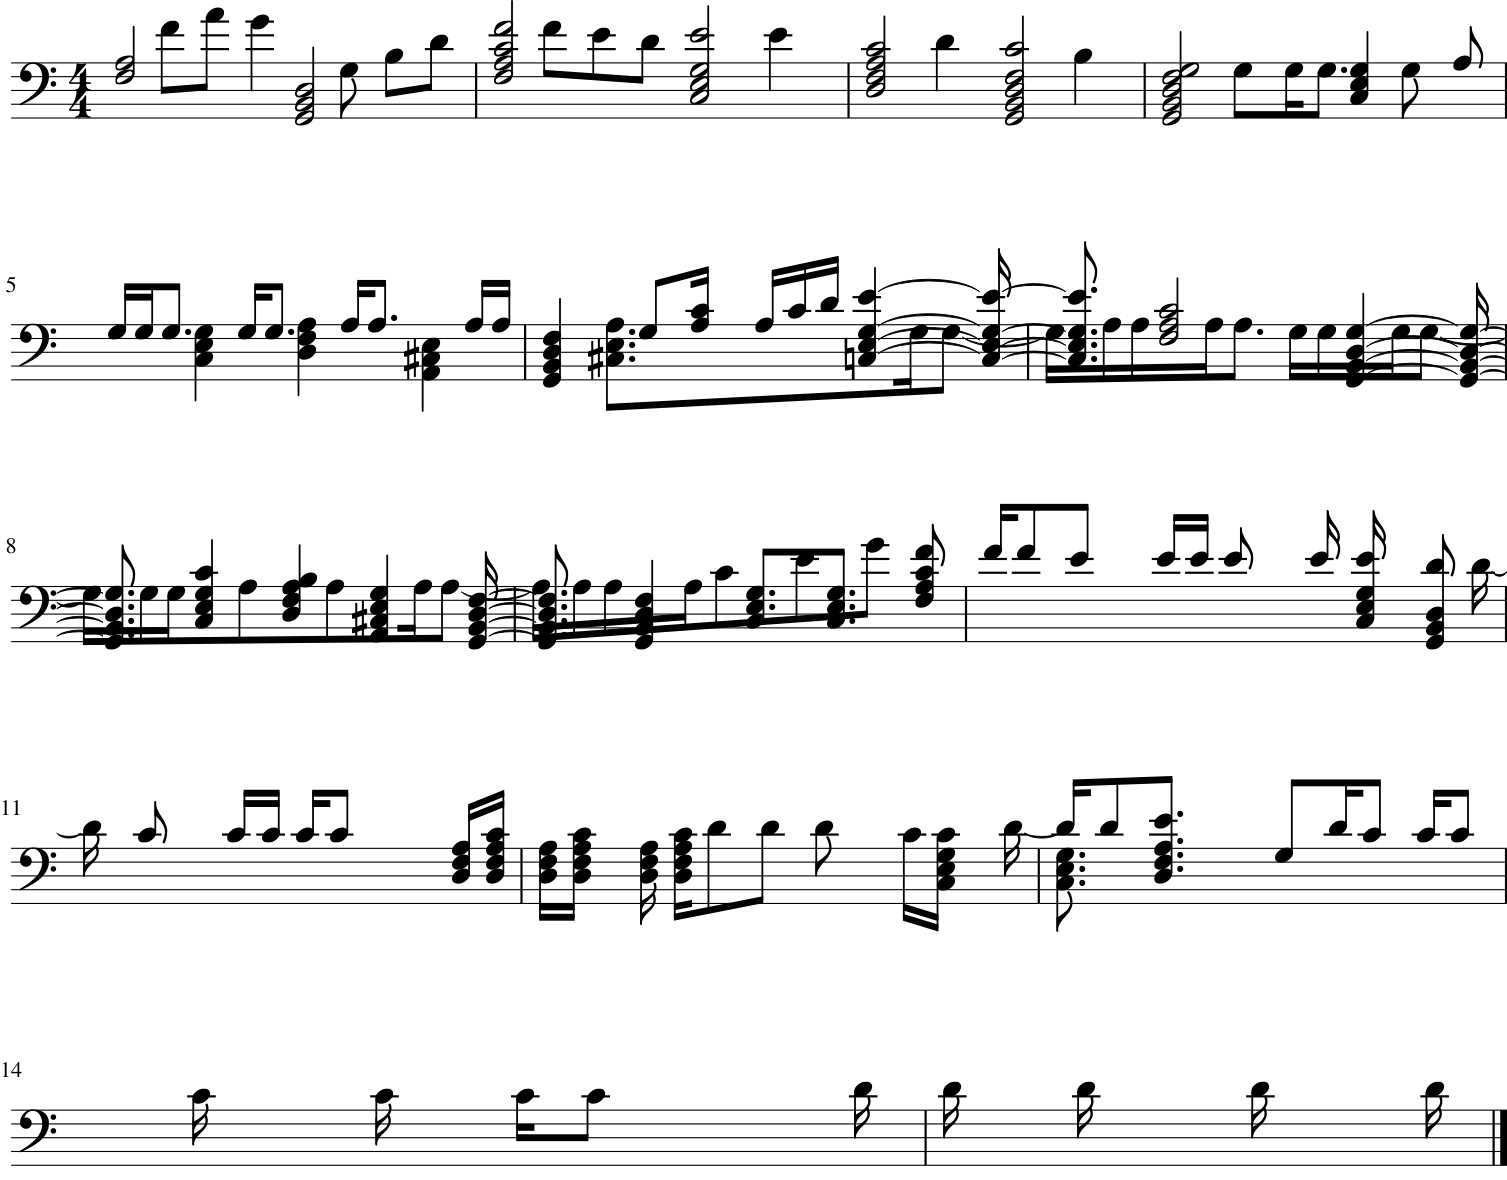

In [39]:
stream = pred2stream(out)
stream.show()

In [40]:
stream.show('midi')

## Seed

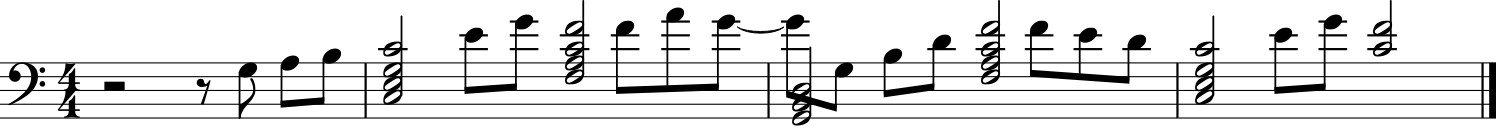

In [33]:
seed_stream = pred2stream(seed)
seed_stream.show()

In [34]:
seed_stream.show('midi')

## Alltogether now

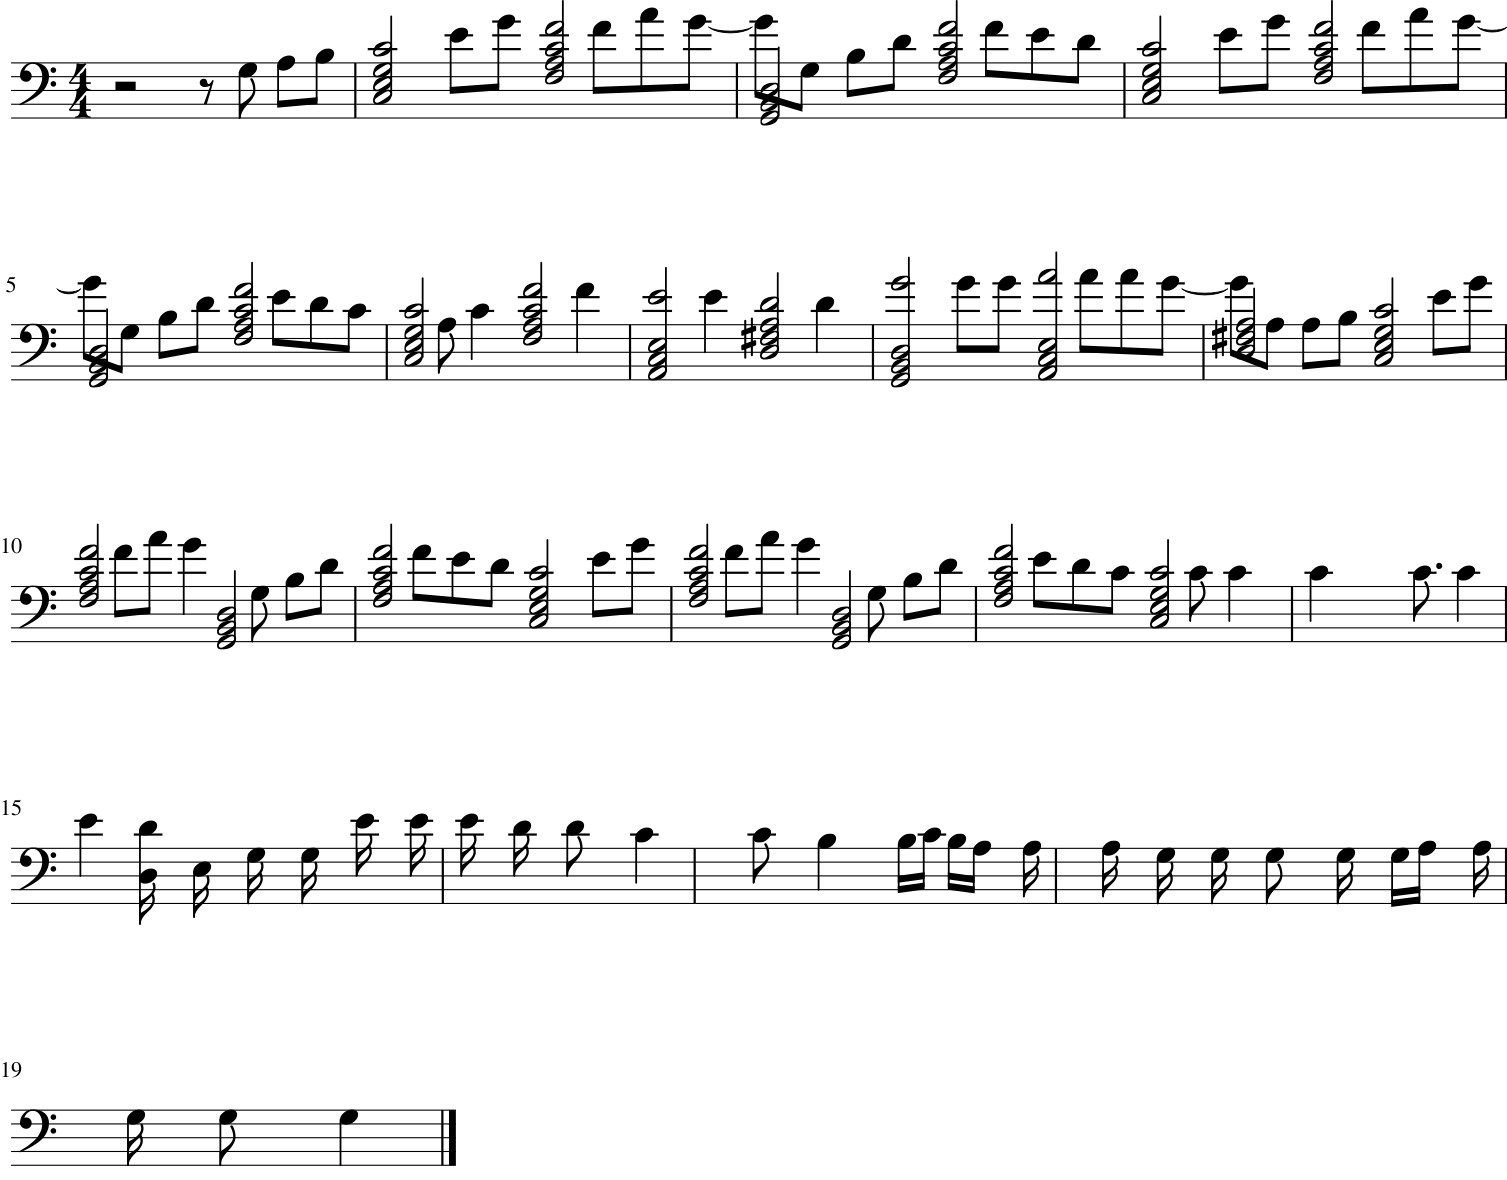

In [35]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = pred2stream(full_output)
full_stream.show()

In [36]:
full_stream.show('midi')